In [1]:
import pandas as pd 
import numpy as np
from xgboost import XGBClassifier
import shap
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

C:\Users\jun99\AppData\Local\Temp\ipykernel_49956\1460297990.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

In [3]:
train = pd.read_csv('../data/train_concat.csv')

ex1 = pd.read_csv('../data_0220_2024/data_0220.csv', encoding='cp949')

In [4]:
ex1.columns = ['연구등록번호', '(실명)등록번호', 'age', 'sex', 'HTN', 'DM', 'tpro', 'alb', 'chol',
       'bun', 'cr', 'eGFR', 'glu', 'plt', 'blood_dip', 'protein_dip',
       'acr_urine', 'pcr_', 'pcr_urine', 'Dysmorphic RBC',
       'G1 dysmorphic', 'glu_urine', 'esterase_urine', 'RBC', 'WBC', 'Biopsy',
       'Reason']
ex1.columns

Index(['연구등록번호', '(실명)등록번호', 'age', 'sex', 'HTN', 'DM', 'tpro', 'alb', 'chol',
       'bun', 'cr', 'eGFR', 'glu', 'plt', 'blood_dip', 'protein_dip',
       'acr_urine', 'pcr_', 'pcr_urine', 'Dysmorphic RBC', 'G1 dysmorphic',
       'glu_urine', 'esterase_urine', 'RBC', 'WBC', 'Biopsy', 'Reason'],
      dtype='object')

In [5]:
ex_copy = ex1[['age', 'sex', 'HTN', 'DM', 'plt', 'alb',
       'bun', 'cr', 'eGFR', 'blood_dip', 'protein_dip',
       'acr_urine', 'pcr_urine', 'glu', 'RBC', 'WBC','Biopsy']].copy()
print(ex_copy.columns)
ex_copy.head()

Index(['age', 'sex', 'HTN', 'DM', 'plt', 'alb', 'bun', 'cr', 'eGFR',
       'blood_dip', 'protein_dip', 'acr_urine', 'pcr_urine', 'glu', 'RBC',
       'WBC', 'Biopsy'],
      dtype='object')


,age,sex,HTN,DM,plt,alb,bun,cr,eGFR,blood_dip,protein_dip,acr_urine,pcr_urine,glu,RBC,WBC,Biopsy
0,52,1,1,0,230,4.5,18.2,1.02,84.112709,2.0,1.0,328.3,0.8571,104,20,2,1
1,38,1,0,0,441,4.4,14.0,1.02,92.805164,3.0,3.0,1224.4,1.8593,88,20,2,0
2,43,1,1,1,196,4.5,9.8,0.62,121.494743,0.0,2.0,185.6,0.2984,276,2,2,0
3,41,1,1,0,283,4.1,25.6,1.44,59.890404,0.0,0.0,8.0,0.0382,104,2,2,0
4,62,1,0,0,186,4.4,14.2,0.65,104.269863,0.0,0.0,8.0,0.1232,90,2,2,0


In [6]:
# train
train['RBC_new'] = train['RBC_re'].apply(lambda x: 1 if 1 > x else 2 if 5> x >= 1 else 3 if 10 > x >= 5 else
                                     4 if 20 > x >= 10 else 5 if 30 > x >= 20 else 6 if 40 > x >= 30 else 
                                     7 if x > 40 else x)

train['WBC_new'] = train['WBC_re'].apply(lambda x: 1 if 1 > x else 2 if 5> x >= 1 else 3 if 10 > x >= 5 else
                                     4 if 20 > x >= 10 else 5 if 30 > x >= 20 else 6 if 40 > x >= 30 else 
                                     7 if x > 40 else x)

In [7]:
print(train['RBC_new'].value_counts().sort_index())
print(train['WBC_new'].value_counts().sort_index()) 
train.head()

RBC_new
1.0     927
2.0    3861
3.0    2697
4.0    3915
5.0    1410
6.0    1317
7.0    4308
Name: count, dtype: int64
WBC_new
1.0     885
2.0    6978
3.0    3168
4.0    3231
5.0    1125
6.0     828
7.0    2070
Name: count, dtype: int64


,age,sex,HTN,DM,plt,tpro,alb,bun,cr,eGFR,...,dysmorphism,RBC_re,WBC_re,RBC_binary,WBC_binary,esterase_binary,group,target,RBC_new,WBC_new
0,48.769863,2,0,0,169.0,6.1,3.5,24.3,1.84,31.676774,...,48.0,79.0,33.4,0,0,1,hr,1,7.0,6.0
1,37.068493,2,0,0,240.0,7.7,5.0,14.1,0.74,103.443334,...,20.0,45.8,31.2,0,0,0,hr,0,7.0,6.0
2,43.323288,2,0,0,337.0,6.8,4.4,8.4,0.60,111.384254,...,29.0,28.9,46.2,0,0,0,hr,0,5.0,7.0
3,71.479452,2,0,0,326.0,6.5,3.7,23.7,1.66,30.585367,...,NaN,4.1,7.2,1,1,1,hr,0,2.0,3.0
4,44.621918,1,1,0,265.0,6.6,4.0,17.5,1.11,79.978350,...,0.0,394.9,97.6,0,0,1,hr,0,7.0,7.0


In [8]:
# ex_copy
ex_copy['RBC_new'] = ex_copy['RBC'].apply(lambda x: 1 if 1 > x else 2 if 5> x >= 1 else 3 if 10 > x >= 5 else
                                     4 if 20 > x >= 10 else 5 if 30 > x >= 20 else 6 if 40 > x >= 30 else 
                                     7 if x > 40 else x)

ex_copy['WBC_new'] = ex_copy['WBC'].apply(lambda x: 1 if 1 > x else 2 if 5> x >= 1 else 3 if 10 > x >= 5 else
                                     4 if 20 > x >= 10 else 5 if 30 > x >= 20 else 6 if 40 > x >= 30 else 
                                     7 if x > 40 else x)

In [9]:
print(ex_copy['RBC_new'].value_counts().sort_index())
print(ex_copy['WBC_new'].value_counts().sort_index()) 
ex_copy.head()

RBC_new
2    411
3     77
4     35
5     38
6     71
Name: count, dtype: int64
WBC_new
1      4
2    472
3     80
4     24
5     28
6     24
Name: count, dtype: int64


,age,sex,HTN,DM,plt,alb,bun,cr,eGFR,blood_dip,protein_dip,acr_urine,pcr_urine,glu,RBC,WBC,Biopsy,RBC_new,WBC_new
0,52,1,1,0,230,4.5,18.2,1.02,84.112709,2.0,1.0,328.3,0.8571,104,20,2,1,5,2
1,38,1,0,0,441,4.4,14.0,1.02,92.805164,3.0,3.0,1224.4,1.8593,88,20,2,0,5,2
2,43,1,1,1,196,4.5,9.8,0.62,121.494743,0.0,2.0,185.6,0.2984,276,2,2,0,2,2
3,41,1,1,0,283,4.1,25.6,1.44,59.890404,0.0,0.0,8.0,0.0382,104,2,2,0,2,2
4,62,1,0,0,186,4.4,14.2,0.65,104.269863,0.0,0.0,8.0,0.1232,90,2,2,0,2,2


In [10]:
test = ex_copy.drop(['Biopsy', 'WBC', 'RBC'], axis=1).copy()
test.head()

,age,sex,HTN,DM,plt,alb,bun,cr,eGFR,blood_dip,protein_dip,acr_urine,pcr_urine,glu,RBC_new,WBC_new
0,52,1,1,0,230,4.5,18.2,1.02,84.112709,2.0,1.0,328.3,0.8571,104,5,2
1,38,1,0,0,441,4.4,14.0,1.02,92.805164,3.0,3.0,1224.4,1.8593,88,5,2
2,43,1,1,1,196,4.5,9.8,0.62,121.494743,0.0,2.0,185.6,0.2984,276,2,2
3,41,1,1,0,283,4.1,25.6,1.44,59.890404,0.0,0.0,8.0,0.0382,104,2,2
4,62,1,0,0,186,4.4,14.2,0.65,104.269863,0.0,0.0,8.0,0.1232,90,2,2


## Modeling

In [11]:
xgb = XGBClassifier(random_state = 2023, n_jobs=-1)

In [12]:
print(test.columns)
print(train.columns)

Index(['age', 'sex', 'HTN', 'DM', 'plt', 'alb', 'bun', 'cr', 'eGFR',
       'blood_dip', 'protein_dip', 'acr_urine', 'pcr_urine', 'glu', 'RBC_new',
       'WBC_new'],
      dtype='object')
Index(['age', 'sex', 'HTN', 'DM', 'plt', 'tpro', 'alb', 'bun', 'cr', 'eGFR',
       'blood_dip', 'protein_dip', 'acr_urine', 'pcr_urine', 'glu',
       'glu_urine', 'esterase_urine', 'dysmorphism', 'RBC_re', 'WBC_re',
       'RBC_binary', 'WBC_binary', 'esterase_binary', 'group', 'target',
       'RBC_new', 'WBC_new'],
      dtype='object')


In [13]:
column_difference = set(test.columns).difference(set(train.columns))
print(f'val - train:{column_difference}')

column_difference = set(train.columns).difference(set(test.columns))
print(f'train - val:{column_difference}')

val - train:set()
train - val:{'dysmorphism', 'group', 'RBC_binary', 'tpro', 'glu_urine', 'WBC_re', 'RBC_re', 'esterase_urine', 'WBC_binary', 'target', 'esterase_binary'}


In [14]:
X_train = train.drop(['glu_urine', 'esterase_urine', 'dysmorphism',
                      'target', 'WBC_re', 'RBC_binary', 'group', 'WBC_binary',
                      'RBC_re', 'tpro', 'esterase_binary'], axis=1).copy()
y_train = train['target'].copy()

In [15]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=2023, ...)

### test

In [16]:
test_pred = xgb.predict(test)
test_pred_prob = xgb.predict_proba(test)

In [17]:
ex_copy['pred'] = test_pred
ex_copy['pred_prob'] = test_pred_prob[:,1]

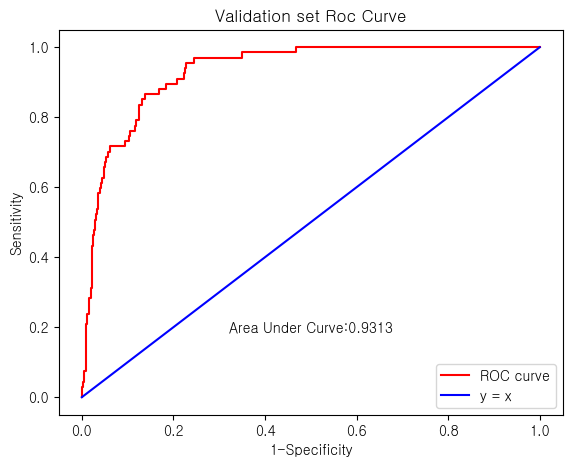

In [45]:
# roc curve, auc validation set
fpr, tpr, thresholds = roc_curve(np.array(ex_copy['Biopsy']), test_pred_prob[:,1])

plt.figure(figsize=(6.5,5))

# auc 계산
plt.plot(fpr, tpr, color = 'red', label = 'ROC curve')
plt.plot([0, 1], [0, 1], color = 'blue', label = 'y = x') # y = x 직선 표시

auc = roc_auc_score(np.array(ex_copy['Biopsy']), test_pred_prob[:,1])
plt.text(0.5, 0.2, f"Area Under Curve:{auc:.4f}", ha='center', va='center', fontsize=10)
plt.title('Validation set Roc Curve')
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')

plt.legend() # 그래프 라벨 표시

plt.show()

In [19]:
accuracy = accuracy_score(ex_copy['Biopsy'], test_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 92.09%


In [20]:
print(classification_report(ex_copy['Biopsy'], test_pred))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96       565
           1       0.66      0.52      0.58        67

    accuracy                           0.92       632
   macro avg       0.80      0.75      0.77       632
weighted avg       0.91      0.92      0.92       632



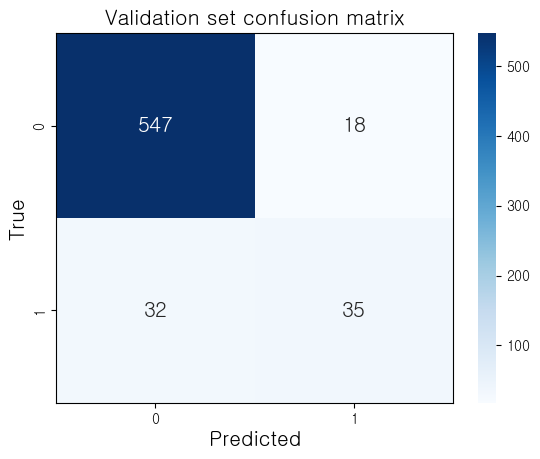

In [21]:
cm = confusion_matrix(ex_copy['Biopsy'], test_pred)

# Plot the confusion matrix with specific formatting for annotations
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Accessing the text elements of the heatmap and setting font properties
for _, spine in heatmap.spines.items():
    spine.set_visible(True)

for t in heatmap.texts:
    t.set_fontsize(15)  # Set the font size here

plt.title('Validation set confusion matrix', fontsize = 15)
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('True', fontsize=15)
plt.show()

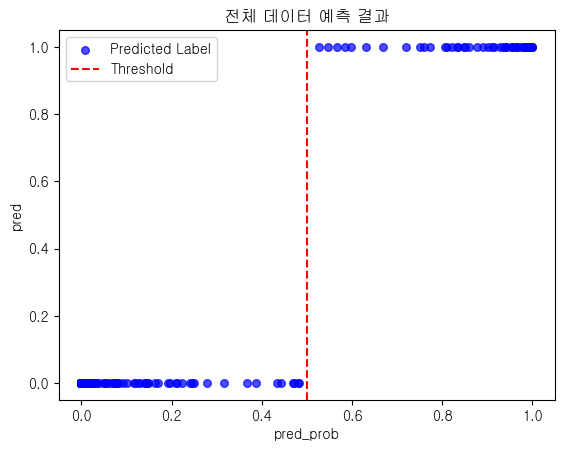

In [22]:
plt.scatter(ex_copy['pred_prob'], ex_copy['pred'], color='blue', label='Predicted Label', alpha=0.7, s=30)

# Add the sigmoid-shaped line at 0.5 threshold
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold')

plt.xlabel('pred_prob')
plt.ylabel('pred')
plt.title('전체 데이터 예측 결과')
plt.legend()
plt.show()

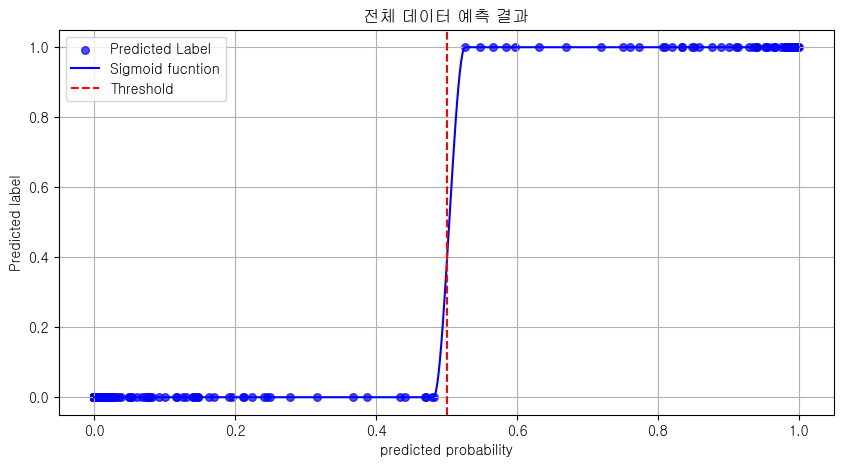

In [37]:
from scipy.interpolate import PchipInterpolator

# 데이터 포인트를 예측 확률에 따라 정렬
sorted_indices = np.argsort(test_pred_prob[:,1])
sorted_ex_copy_pred_prob = test_pred_prob[:,1][sorted_indices]
sorted_ex_copy_pred = test_pred[sorted_indices]

# PchipInterpolator를 사용하여 보간 객체 생성
f = PchipInterpolator(sorted_ex_copy_pred_prob, sorted_ex_copy_pred)

# 보간 함수를 사용하여 곡선 생성을 위한 y 값 계산
x_new = np.linspace(min(sorted_ex_copy_pred_prob), max(sorted_ex_copy_pred_prob), 500)
y_smooth = f(x_new)

# 그래프 그리기
plt.figure(figsize=(10,5))
plt.scatter(test_pred_prob[:,1], test_pred, color='blue', label='Predicted Label', alpha=0.7, s=30)
plt.plot(x_new, y_smooth, color='blue', label='Sigmoid fucntion')

# 기타 그래프 설정
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold')
plt.xlabel('predicted probability')
plt.ylabel('Predicted label')
plt.title('전체 데이터 예측 결과')
plt.legend()
plt.grid(True)
plt.show()

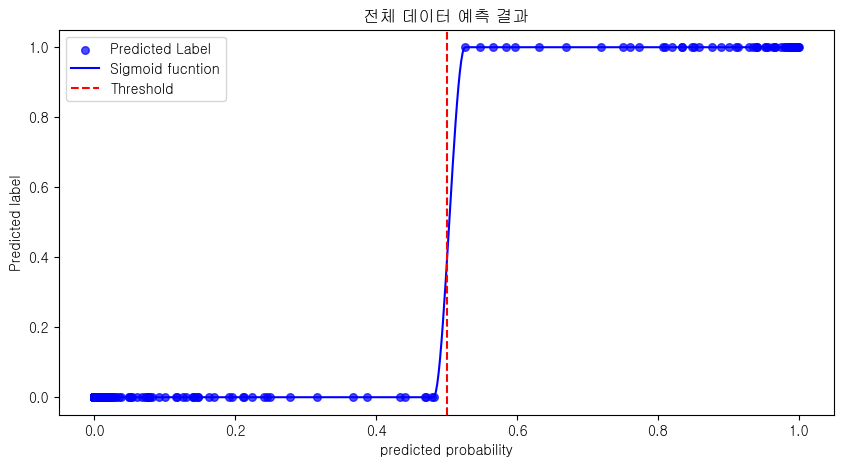

In [38]:
from scipy.interpolate import PchipInterpolator

# 데이터 포인트를 예측 확률에 따라 정렬
sorted_indices = np.argsort(test_pred_prob[:,1])
sorted_ex_copy_pred_prob = test_pred_prob[:,1][sorted_indices]
sorted_ex_copy_pred = test_pred[sorted_indices]

# PchipInterpolator를 사용하여 보간 객체 생성
f = PchipInterpolator(sorted_ex_copy_pred_prob, sorted_ex_copy_pred)

# 보간 함수를 사용하여 곡선 생성을 위한 y 값 계산
x_new = np.linspace(min(sorted_ex_copy_pred_prob), max(sorted_ex_copy_pred_prob), 500)
y_smooth = f(x_new)

# 그래프 그리기
plt.figure(figsize=(10,5))
plt.scatter(test_pred_prob[:,1], test_pred, color='blue', label='Predicted Label', alpha=0.7, s=30)
plt.plot(x_new, y_smooth, color='blue', label='Sigmoid fucntion')

# 기타 그래프 설정
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold')
plt.xlabel('predicted probability')
plt.ylabel('Predicted label')
plt.title('전체 데이터 예측 결과')
plt.legend()
plt.grid(False)
plt.show()

### 10% 중간 영역 제외

In [23]:
ex_copy.pred_prob.head()

0    0.223340
1    0.995018
2    0.000006
3    0.000158
4    0.000015
Name: pred_prob, dtype: float32

In [24]:
# 8개 제외됨
ex_copy_no_middle_10 = ex_copy[(ex_copy['pred_prob'] <= 0.45) | (ex_copy['pred_prob'] >= 0.55)].copy()
print(ex_copy_no_middle_10.shape)
ex_copy_no_middle_10.head()

(626, 21)


,age,sex,HTN,DM,plt,alb,bun,cr,eGFR,blood_dip,...,acr_urine,pcr_urine,glu,RBC,WBC,Biopsy,RBC_new,WBC_new,pred,pred_prob
0,52,1,1,0,230,4.5,18.2,1.02,84.112709,2.0,...,328.3,0.8571,104,20,2,1,5,2,0,0.223340
1,38,1,0,0,441,4.4,14.0,1.02,92.805164,3.0,...,1224.4,1.8593,88,20,2,0,5,2,1,0.995018
2,43,1,1,1,196,4.5,9.8,0.62,121.494743,0.0,...,185.6,0.2984,276,2,2,0,2,2,0,0.000006
3,41,1,1,0,283,4.1,25.6,1.44,59.890404,0.0,...,8.0,0.0382,104,2,2,0,2,2,0,0.000158
4,62,1,0,0,186,4.4,14.2,0.65,104.269863,0.0,...,8.0,0.1232,90,2,2,0,2,2,0,0.000015


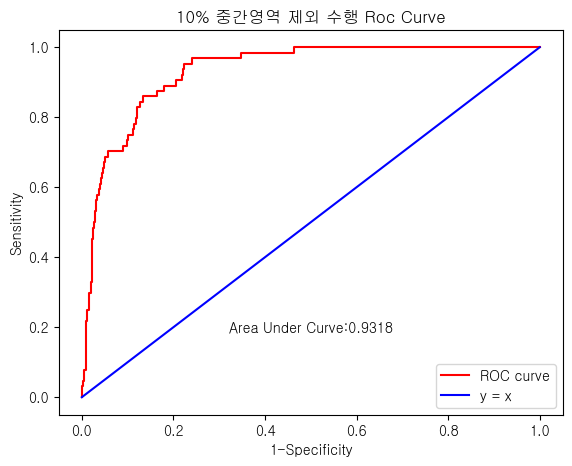

In [46]:
# roc curve, auc validation set
fpr, tpr, thresholds = roc_curve(np.array(ex_copy_no_middle_10['Biopsy']), ex_copy_no_middle_10['pred_prob'])

plt.figure(figsize=(6.5,5))

# auc 계산
plt.plot(fpr, tpr, color = 'red', label = 'ROC curve')
plt.plot([0, 1], [0, 1], color = 'blue', label = 'y = x') # y = x 직선 표시

auc = roc_auc_score(np.array(ex_copy_no_middle_10['Biopsy']), ex_copy_no_middle_10['pred_prob'])
plt.text(0.5, 0.2, f"Area Under Curve:{auc:.4f}", ha='center', va='center', fontsize=10)
plt.title('10% 중간영역 제외 수행 Roc Curve')
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')

plt.legend() # 그래프 라벨 표시

plt.show()

In [26]:
accuracy = accuracy_score(ex_copy_no_middle_10['Biopsy'], ex_copy_no_middle_10['pred'])
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 92.49%


In [27]:
print(classification_report(ex_copy_no_middle_10['Biopsy'], ex_copy_no_middle_10['pred']))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       562
           1       0.67      0.53      0.59        64

    accuracy                           0.92       626
   macro avg       0.81      0.75      0.77       626
weighted avg       0.92      0.92      0.92       626



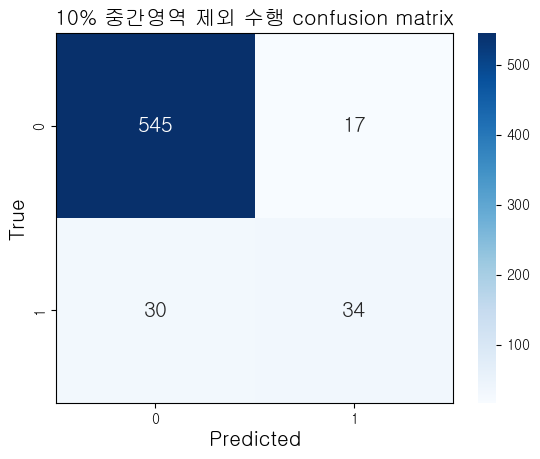

In [28]:
cm = confusion_matrix(ex_copy_no_middle_10['Biopsy'], ex_copy_no_middle_10['pred'])

# Plot the confusion matrix with specific formatting for annotations
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Accessing the text elements of the heatmap and setting font properties
for _, spine in heatmap.spines.items():
    spine.set_visible(True)

for t in heatmap.texts:
    t.set_fontsize(15)  # Set the font size here

plt.title('10% 중간영역 제외 수행 confusion matrix', fontsize = 15)
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('True', fontsize=15)
plt.show()

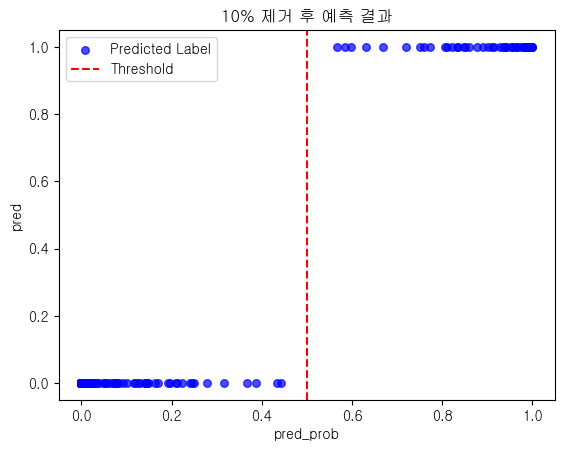

In [29]:
plt.scatter(ex_copy_no_middle_10['pred_prob'], ex_copy_no_middle_10['pred'], color='blue', label='Predicted Label', alpha=0.7, s=30)

# Add the sigmoid-shaped line at 0.5 threshold
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold')

plt.xlabel('pred_prob')
plt.ylabel('pred')
plt.title('10% 제거 후 예측 결과')
plt.legend()
plt.show()

In [39]:
middle_10_pred_prob = np.array(ex_copy_no_middle_10['pred_prob'])
middle_10_pred = np.array(ex_copy_no_middle_10['pred'])

print(len(middle_10_pred_prob))
print(len(ex_copy_no_middle_10['pred_prob']))

626
626


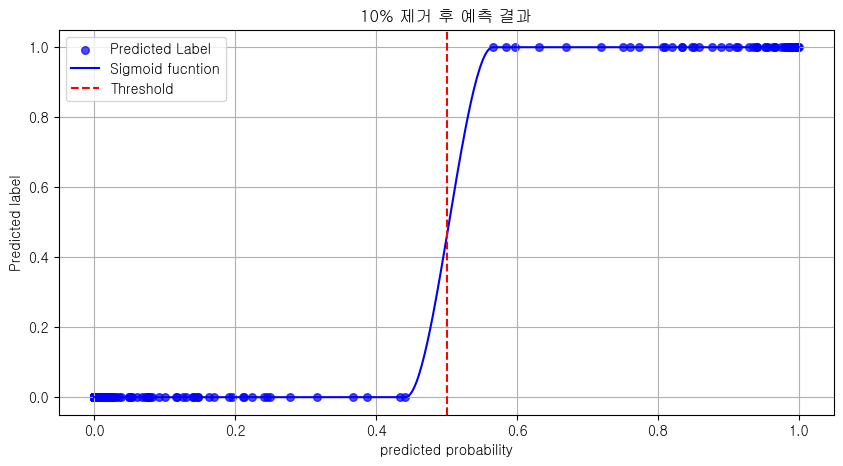

In [40]:
from scipy.interpolate import PchipInterpolator

# 데이터 포인트를 예측 확률에 따라 정렬
sorted_indices = np.argsort(middle_10_pred_prob)
sorted_ex_copy_pred_prob = middle_10_pred_prob[sorted_indices]
sorted_ex_copy_pred = middle_10_pred[sorted_indices]

# PchipInterpolator를 사용하여 보간 객체 생성
f = PchipInterpolator(sorted_ex_copy_pred_prob, sorted_ex_copy_pred)

# 보간 함수를 사용하여 곡선 생성을 위한 y 값 계산
x_new = np.linspace(min(sorted_ex_copy_pred_prob), max(sorted_ex_copy_pred_prob), 500)
y_smooth = f(x_new)

# 그래프 그리기
plt.figure(figsize=(10,5))
plt.scatter(middle_10_pred_prob, middle_10_pred, color='blue', label='Predicted Label', alpha=0.7, s=30)
plt.plot(x_new, y_smooth, color='blue', label='Sigmoid fucntion')

# 기타 그래프 설정
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold')
plt.xlabel('predicted probability')
plt.ylabel('Predicted label')
plt.title('10% 제거 후 예측 결과')
plt.legend()
plt.grid(True)
plt.show()

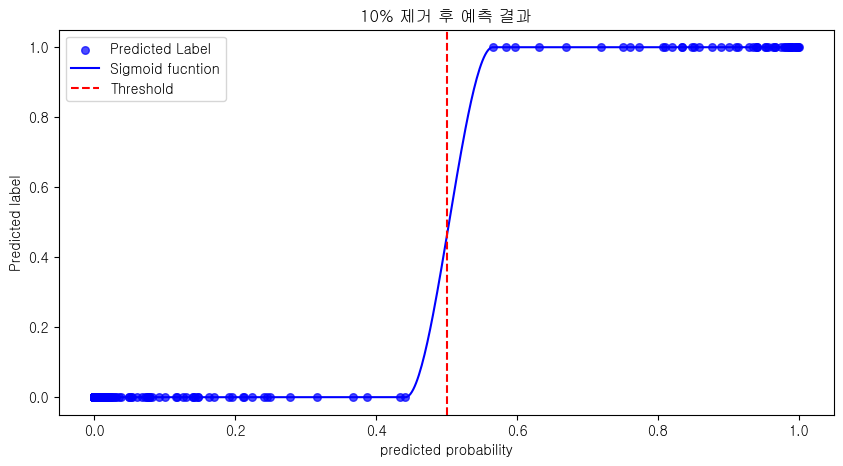

In [41]:
from scipy.interpolate import PchipInterpolator

# 데이터 포인트를 예측 확률에 따라 정렬
sorted_indices = np.argsort(middle_10_pred_prob)
sorted_ex_copy_pred_prob = middle_10_pred_prob[sorted_indices]
sorted_ex_copy_pred = middle_10_pred[sorted_indices]

# PchipInterpolator를 사용하여 보간 객체 생성
f = PchipInterpolator(sorted_ex_copy_pred_prob, sorted_ex_copy_pred)

# 보간 함수를 사용하여 곡선 생성을 위한 y 값 계산
x_new = np.linspace(min(sorted_ex_copy_pred_prob), max(sorted_ex_copy_pred_prob), 500)
y_smooth = f(x_new)

# 그래프 그리기
plt.figure(figsize=(10,5))
plt.scatter(middle_10_pred_prob, middle_10_pred, color='blue', label='Predicted Label', alpha=0.7, s=30)
plt.plot(x_new, y_smooth, color='blue', label='Sigmoid fucntion')

# 기타 그래프 설정
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold')
plt.xlabel('predicted probability')
plt.ylabel('Predicted label')
plt.title('10% 제거 후 예측 결과')
plt.legend()
plt.grid(False)
plt.show()

### 20% 중간 영역 제외

In [30]:
ex_copy.pred_prob.head()

0    0.223340
1    0.995018
2    0.000006
3    0.000158
4    0.000015
Name: pred_prob, dtype: float32

In [31]:
# 8개 제외됨
ex_copy_no_middle = ex_copy[(ex_copy['pred_prob'] < 0.4) | (ex_copy['pred_prob'] > 0.6)].copy()
print(ex_copy_no_middle.shape)
ex_copy_no_middle.head()

(621, 21)


,age,sex,HTN,DM,plt,alb,bun,cr,eGFR,blood_dip,...,acr_urine,pcr_urine,glu,RBC,WBC,Biopsy,RBC_new,WBC_new,pred,pred_prob
0,52,1,1,0,230,4.5,18.2,1.02,84.112709,2.0,...,328.3,0.8571,104,20,2,1,5,2,0,0.223340
1,38,1,0,0,441,4.4,14.0,1.02,92.805164,3.0,...,1224.4,1.8593,88,20,2,0,5,2,1,0.995018
2,43,1,1,1,196,4.5,9.8,0.62,121.494743,0.0,...,185.6,0.2984,276,2,2,0,2,2,0,0.000006
3,41,1,1,0,283,4.1,25.6,1.44,59.890404,0.0,...,8.0,0.0382,104,2,2,0,2,2,0,0.000158
4,62,1,0,0,186,4.4,14.2,0.65,104.269863,0.0,...,8.0,0.1232,90,2,2,0,2,2,0,0.000015


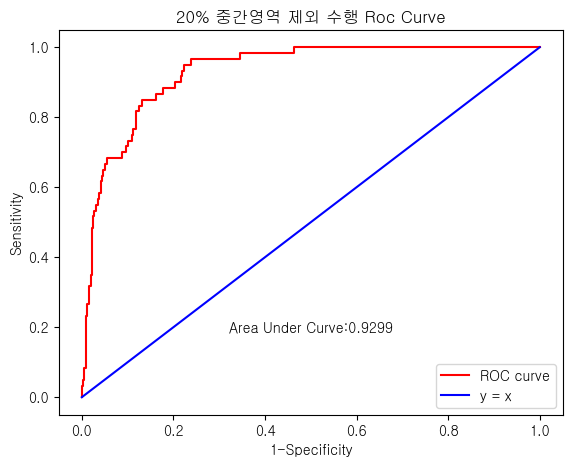

In [47]:
# roc curve, auc validation set
fpr, tpr, thresholds = roc_curve(np.array(ex_copy_no_middle['Biopsy']), ex_copy_no_middle['pred_prob'])

plt.figure(figsize=(6.5,5))

# auc 계산
plt.plot(fpr, tpr, color = 'red', label = 'ROC curve')
plt.plot([0, 1], [0, 1], color = 'blue', label = 'y = x') # y = x 직선 표시

auc = roc_auc_score(np.array(ex_copy_no_middle['Biopsy']), ex_copy_no_middle['pred_prob'])
plt.text(0.5, 0.2, f"Area Under Curve:{auc:.4f}", ha='center', va='center', fontsize=10)
plt.title('20% 중간영역 제외 수행 Roc Curve')
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')

plt.legend() # 그래프 라벨 표시

plt.show()

In [33]:
accuracy = accuracy_score(ex_copy_no_middle['Biopsy'], ex_copy_no_middle['pred'])
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 92.91%


In [34]:
print(classification_report(ex_copy_no_middle['Biopsy'], ex_copy_no_middle['pred']))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       561
           1       0.67      0.53      0.59        60

    accuracy                           0.93       621
   macro avg       0.81      0.75      0.78       621
weighted avg       0.92      0.93      0.93       621



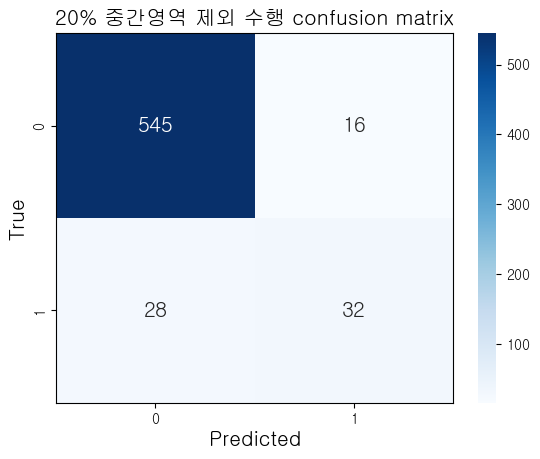

In [35]:
cm = confusion_matrix(ex_copy_no_middle['Biopsy'], ex_copy_no_middle['pred'])

# Plot the confusion matrix with specific formatting for annotations
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Accessing the text elements of the heatmap and setting font properties
for _, spine in heatmap.spines.items():
    spine.set_visible(True)

for t in heatmap.texts:
    t.set_fontsize(15)  # Set the font size here

plt.title('20% 중간영역 제외 수행 confusion matrix', fontsize = 15)
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('True', fontsize=15)
plt.show()

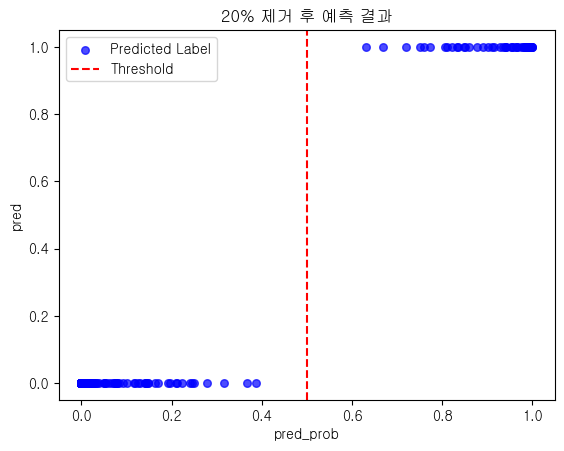

In [36]:
plt.scatter(ex_copy_no_middle['pred_prob'], ex_copy_no_middle['pred'], color='blue', label='Predicted Label', alpha=0.7, s=30)

# Add the sigmoid-shaped line at 0.5 threshold
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold')

plt.xlabel('pred_prob')
plt.ylabel('pred')
plt.title('20% 제거 후 예측 결과')
plt.legend()
plt.show()

In [42]:
middle_pred_prob = np.array(ex_copy_no_middle['pred_prob'])
middle_pred = np.array(ex_copy_no_middle['pred'])

print(len(middle_pred_prob))
print(len(ex_copy_no_middle['pred_prob']))

621
621


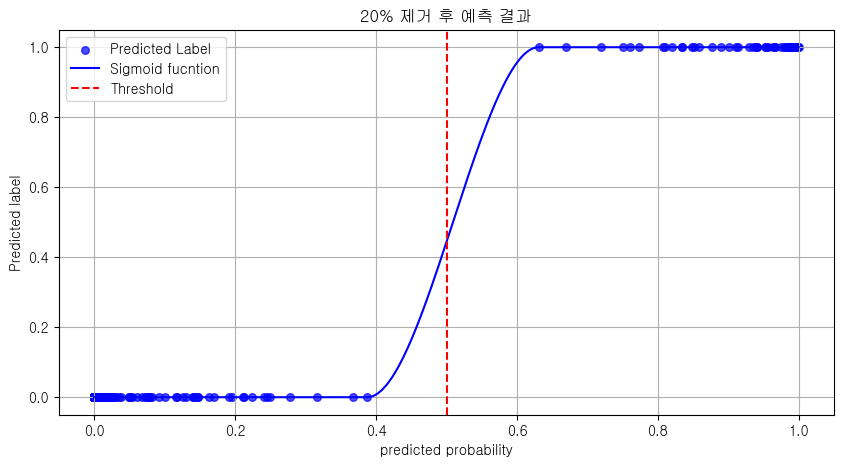

In [43]:
from scipy.interpolate import PchipInterpolator

# 데이터 포인트를 예측 확률에 따라 정렬
sorted_indices = np.argsort(middle_pred_prob)
sorted_ex_copy_pred_prob = middle_pred_prob[sorted_indices]
sorted_ex_copy_pred = middle_pred[sorted_indices]

# PchipInterpolator를 사용하여 보간 객체 생성
f = PchipInterpolator(sorted_ex_copy_pred_prob, sorted_ex_copy_pred)

# 보간 함수를 사용하여 곡선 생성을 위한 y 값 계산
x_new = np.linspace(min(sorted_ex_copy_pred_prob), max(sorted_ex_copy_pred_prob), 500)
y_smooth = f(x_new)

# 그래프 그리기
plt.figure(figsize=(10,5))
plt.scatter(middle_pred_prob, middle_pred, color='blue', label='Predicted Label', alpha=0.7, s=30)
plt.plot(x_new, y_smooth, color='blue', label='Sigmoid fucntion')

# 기타 그래프 설정
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold')
plt.xlabel('predicted probability')
plt.ylabel('Predicted label')
plt.title('20% 제거 후 예측 결과')
plt.legend()
plt.grid(True)
plt.show()

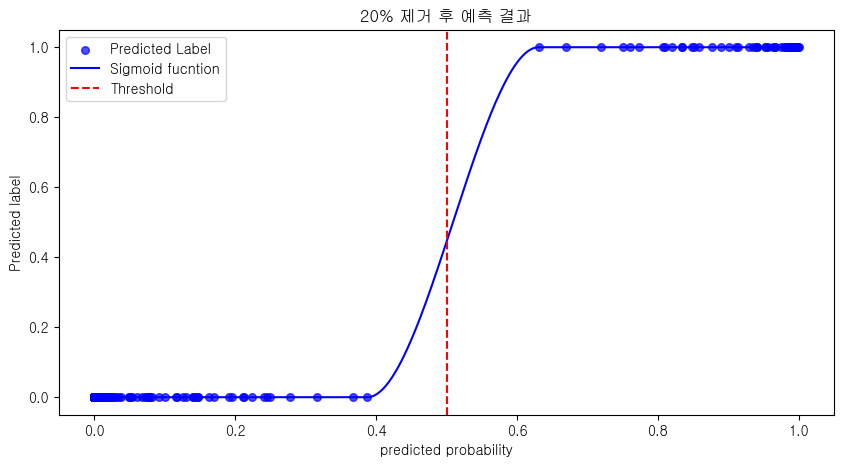

In [44]:
from scipy.interpolate import PchipInterpolator

# 격자 없이 
# 데이터 포인트를 예측 확률에 따라 정렬
sorted_indices = np.argsort(middle_pred_prob)
sorted_ex_copy_pred_prob = middle_pred_prob[sorted_indices]
sorted_ex_copy_pred = middle_pred[sorted_indices]

# PchipInterpolator를 사용하여 보간 객체 생성
f = PchipInterpolator(sorted_ex_copy_pred_prob, sorted_ex_copy_pred)

# 보간 함수를 사용하여 곡선 생성을 위한 y 값 계산
x_new = np.linspace(min(sorted_ex_copy_pred_prob), max(sorted_ex_copy_pred_prob), 500)
y_smooth = f(x_new)

# 그래프 그리기
plt.figure(figsize=(10,5))
plt.scatter(middle_pred_prob, middle_pred, color='blue', label='Predicted Label', alpha=0.7, s=30)
plt.plot(x_new, y_smooth, color='blue', label='Sigmoid fucntion')

# 기타 그래프 설정
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold')
plt.xlabel('predicted probability')
plt.ylabel('Predicted label')
plt.title('20% 제거 후 예측 결과')
plt.legend()
plt.grid(False)
plt.show()